# 仓储需求预测分析2


数据下载地址（和之前的数据是一样的，包含了原始赛题与数据说明，此数据只包含了部分赛题数据）：https://pan.baidu.com/s/1R4dgFyDruxBrz-jWbMN8qw

本案例简化了原有的赛题：这里我们预测15年10月份最后一个星期的销量，只考虑全国总仓销量，对应的目标字段为："qty_alipay_njhs"

## 数据的导入

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pylab
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
tp=pd.read_csv(r"F:\data\tianchi\wuliu\part2\item_feature2.csv",sep=",",names=["date","item_id","cate_id","cate_level_id","brand_id","supplier_id","pv_ipv",
                                       "pv_uv","cart_ipv","cart_uv","collect_uv","num_gmv","amt_gmv","qty_gmv","unum_gmv"
                                       ,"amt_alipay","num_alipay","qty_alipay","unum_alipay","ztc_pv_ipv","tbk_pv_ipv",
                                       "ss_pv_ipv","jhs_pv_ipv","ztc_pv_uv","tbk_pv_uv","ss_pv_uv","jhs_pv_uv","num_alipay_njhs",
                                       "amt_alipay_njhs","qty_alipay_njhs","unum_alipay_njhs"],parse_dates=["date"])#把date字段转换为日期类型

In [3]:
tp.head()

,date,item_id,cate_id,cate_level_id,brand_id,supplier_id,pv_ipv,pv_uv,cart_ipv,cart_uv,...,ss_pv_ipv,jhs_pv_ipv,ztc_pv_uv,tbk_pv_uv,ss_pv_uv,jhs_pv_uv,num_alipay_njhs,amt_alipay_njhs,qty_alipay_njhs,unum_alipay_njhs
0,2015-11-07,100038,37,11,480,1162,2,1,0,0,...,0,0,0,0,0,0,0,0.0,0,0
1,2015-08-09,100038,37,11,480,1162,3,1,0,0,...,0,0,0,0,0,0,0,0.0,0,0
2,2015-11-10,100038,37,11,480,1162,19,3,3,2,...,0,0,0,0,0,0,0,0.0,0,0
3,2015-09-25,100038,37,11,480,1162,4,2,0,0,...,0,0,0,0,0,0,0,0.0,0,0
4,2015-07-26,100038,37,11,480,1162,2,2,0,0,...,2,0,0,0,2,0,0,0.0,0,0


# 特征工程

* 商品种类多样
* 商品会上架下架
* 商品会做活动，因此销量有剧烈变化的情况
* 同类商品有竞争

## 各个行为按周的统计特征

In [4]:
feature_1=tp.groupby([pd.Grouper(key="date",freq="W"),"item_id","cate_id","cate_level_id","brand_id","supplier_id"]).agg(["sum","std","max","mean"])

In [5]:
feature_1.head()

pv_ipv  \
                                                                 sum   
date       item_id cate_id cate_level_id brand_id supplier_id          
2014-10-12 132     18      12            203      1976             5   
           330     20      5             400      1556            66   
           903     17      12            666      431           2914   
           1013    39      12            406      1335            53   
           1053    37      11            480      673            285   

                                                                           \
                                                                      std   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           8.544004   
           903     17      12            666      431          301.737192   
           1013    39      12            406      1335           4.041452   
           1053    37      11            480      673           19.078784   

                                                                     \
                                                                max   
date       item_id cate_id cate_level_id brand_id supplier_id         
2014-10-12 132     18      12            203      1976            3   
           330     20      5             400      1556           31   
           903     17      12            666      431          1242   
           1013    39      12            406      1335           22   
           1053    37      11            480      673           115   

                                                                           \
                                                                     mean   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.666667   
           330     20      5             400      1556          22.000000   
           903     17      12            666      431          971.333333   
           1013    39      12            406      1335          17.666667   
           1053    37      11            480      673           95.000000   

                                                              pv_uv  \
                                                                sum   
date       item_id cate_id cate_level_id brand_id supplier_id         
2014-10-12 132     18      12            203      1976            5   
           330     20      5             400      1556           37   
           903     17      12            666      431          1785   
           1013    39      12            406      1335           37   
           1053    37      11            480      673           148   

                                                                           \
                                                                      std   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           3.214550   
           903     17      12            666      431          216.016203   
           1013    39      12            406      1335           0.577350   
           1053    37      11            480      673           11.846237   

                                                                    \
                                                               max   
date       item_id cate_id cate_level_id brand_id supplier_id        
2014-10-12 132     18      12            203      1976           3   
           330     20      5             400      1556          16   
           903     17      12            666      431          792   
           1013    39      12            406      1335          13   
      

## 各个行为在最近1天，2天，4天的总量（sum）

In [9]:
#weekday用来把日期转换为星期
k=0
for i in tp.date.items():
    print(i[1].weekday())
    k=k+1
    if k==4:break

5
6
1
4


In [11]:
def c1(x):
    if x.weekday()==6:
        return "6"
    elif x.weekday()>=4:
        return "45"
    else:
        return "0123"

weekday0=tp.date.apply(c1)#通过c1函数把日期转换为我们想区分的各个时间区间
weekday0.name="weekday0"

In [14]:
weekday0.head()

0      45
1       6
2    0123
3      45
4       6
Name: weekday0, dtype: object

In [12]:
tp1=pd.concat([tp,weekday0], axis=1)

In [15]:
tp1.head()

,date,item_id,cate_id,cate_level_id,brand_id,supplier_id,pv_ipv,pv_uv,cart_ipv,cart_uv,...,jhs_pv_ipv,ztc_pv_uv,tbk_pv_uv,ss_pv_uv,jhs_pv_uv,num_alipay_njhs,amt_alipay_njhs,qty_alipay_njhs,unum_alipay_njhs,weekday0
0,2015-11-07,100038,37,11,480,1162,2,1,0,0,...,0,0,0,0,0,0,0.0,0,0,45
1,2015-08-09,100038,37,11,480,1162,3,1,0,0,...,0,0,0,0,0,0,0.0,0,0,6
2,2015-11-10,100038,37,11,480,1162,19,3,3,2,...,0,0,0,0,0,0,0.0,0,0,0123
3,2015-09-25,100038,37,11,480,1162,4,2,0,0,...,0,0,0,0,0,0,0.0,0,0,45
4,2015-07-26,100038,37,11,480,1162,2,2,0,0,...,0,0,0,2,0,0,0.0,0,0,6


In [216]:
#tp1.groupby([pd.Grouper(key="date",freq="W"),"item_id","cate_id","cate_level_id","brand_id","supplier_id","weekday0"]).sum()

In [16]:
#得到每周最后1天（星期天），2天（星期六，五），4天（其他）的各个行为量
feature_2=tp1.groupby([pd.Grouper(key="date",freq="W"),"item_id","cate_id","cate_level_id","brand_id","supplier_id","weekday0"]).sum()
feature_2=feature_2.fillna(0).unstack(level=-1,fill_value=0)

In [17]:
feature_2.head()

pv_ipv        \
weekday0                                                        0123    45   
date       item_id cate_id cate_level_id brand_id supplier_id                
2014-10-12 132     18      12            203      1976             0     4   
           330     20      5             400      1556             0    52   
           903     17      12            666      431              0  1672   
           1013    39      12            406      1335             0    31   
           1053    37      11            480      673              0   170   

                                                                    pv_uv  \
weekday0                                                          6  0123   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976            1     0   
           330     20      5             400      1556           14     0   
           903     17      12            666      431          1242     0   
           1013    39      12            406      1335           22     0   
           1053    37      11            480      673           115     0   

                                                                         \
weekday0                                                        45    6   
date       item_id cate_id cate_level_id brand_id supplier_id             
2014-10-12 132     18      12            203      1976           4    1   
           330     20      5             400      1556          27   10   
           903     17      12            666      431          993  792   
           1013    39      12            406      1335          25   12   
           1053    37      11            480      673           85   63   

                                                              cart_ipv      \
weekday0                                                          0123  45   
date       item_id cate_id cate_level_id brand_id supplier_id                
2014-10-12 132     18      12            203      1976               0   0   
           330     20      5             400      1556               0   0   
           903     17      12            666      431                0  28   
           1013    39      12            406      1335               0   4   
           1053    37      11            480      673                0  21   

                                                                  cart_uv ...  \
weekday0                                                        6    0123 ...   
date       item_id cate_id cate_level_id brand_id supplier_id             ...   
2014-10-12 132     18      12            203      1976          0       0 ...   
           330     20      5             400      1556          0       0 ...   
           903     17      12            666      431          21       0 ...   
           1013    39      12            406      1335          0       0 ...   
           1053    37      11            480      673           6       0 ...   

                                                              num_alipay_njhs  \
weekday0                                                                    6   
date       item_id cate_id cate_level_id brand_id supplier_id                   
2014-10-12 132     18      12            203      1976                      0   
           330     20      5             400      1556                      0   
           903     17      12            666      431                       2   
           1013    39      12            406      1335                      0   
           1053    37      11            480      673                       0   

                                                              amt_alipay_njhs  \
weekday0                                                                 0123   
date       item_id cate_id cate_level_id brand_id supplier_id                   
2014-10-12 132     18      12            203      197

### 各个类目（cate_id）与品牌(brand_id)的周度总销量

* 为什么不做独热特征

In [73]:
feature_cate_id=tp.loc[:,["date","cate_id","qty_alipay_njhs"]].groupby([pd.Grouper(key="date",freq="W"),"cate_id"]).sum()
feature_brand_id=tp.loc[:,["date","brand_id","qty_alipay_njhs"]].groupby([pd.Grouper(key="date",freq="W"),"brand_id"]).sum()

In [20]:
#feature_cate_id.head()
feature_brand_id.head()

qty_alipay_njhs
date       brand_id                 
2014-10-12 2                       2
           3                       3
           6                       0
           26                      6
           35                     45

### 三方面特征合并

In [75]:
feature_12=pd.concat([feature_1,feature_2],axis=1,join_axes=[feature_1.index])#feature_1的索引是最全的，所以以feature_1为准
feature_12=feature_12.fillna(0)

In [76]:
feature_12.head()

pv_ipv  \
                                                                 sum   
date       item_id cate_id cate_level_id brand_id supplier_id          
2014-10-12 132     18      12            203      1976             5   
           330     20      5             400      1556            66   
           903     17      12            666      431           2914   
           1013    39      12            406      1335            53   
           1053    37      11            480      673            285   

                                                                           \
                                                                      std   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           8.544004   
           903     17      12            666      431          301.737192   
           1013    39      12            406      1335           4.041452   
           1053    37      11            480      673           19.078784   

                                                                     \
                                                                max   
date       item_id cate_id cate_level_id brand_id supplier_id         
2014-10-12 132     18      12            203      1976            3   
           330     20      5             400      1556           31   
           903     17      12            666      431          1242   
           1013    39      12            406      1335           22   
           1053    37      11            480      673           115   

                                                                           \
                                                                     mean   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.666667   
           330     20      5             400      1556          22.000000   
           903     17      12            666      431          971.333333   
           1013    39      12            406      1335          17.666667   
           1053    37      11            480      673           95.000000   

                                                              pv_uv  \
                                                                sum   
date       item_id cate_id cate_level_id brand_id supplier_id         
2014-10-12 132     18      12            203      1976            5   
           330     20      5             400      1556           37   
           903     17      12            666      431          1785   
           1013    39      12            406      1335           37   
           1053    37      11            480      673           148   

                                                                           \
                                                                      std   
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           3.214550   
           903     17      12            666      431          216.016203   
           1013    39      12            406      1335           0.577350   
           1053    37      11            480      673           11.846237   

                                                                    \
                                                               max   
date       item_id cate_id cate_level_id brand_id supplier_id        
2014-10-12 132     18      12            203      1976           3   
           330     20      5             400      1556          16   
           903     17      12            666      431          792   
           1013    39      12            406      1335          13   
      

In [24]:
#feature_12.columns.ravel()

In [77]:
feature_12_0 = feature_12.copy(deep=True)#深复制
feature_12_0.columns = ["_".join(x) for x in feature_12.columns.ravel()]

In [68]:
feature_12_0.head()

pv_ipv_sum  \
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976                  5   
           330     20      5             400      1556                 66   
           903     17      12            666      431                2914   
           1013    39      12            406      1335                 53   
           1053    37      11            480      673                 285   

                                                               pv_ipv_std  \
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           8.544004   
           903     17      12            666      431          301.737192   
           1013    39      12            406      1335           4.041452   
           1053    37      11            480      673           19.078784   

                                                               pv_ipv_max  \
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976                  3   
           330     20      5             400      1556                 31   
           903     17      12            666      431                1242   
           1013    39      12            406      1335                 22   
           1053    37      11            480      673                 115   

                                                               pv_ipv_mean  \
date       item_id cate_id cate_level_id brand_id supplier_id                
2014-10-12 132     18      12            203      1976            1.666667   
           330     20      5             400      1556           22.000000   
           903     17      12            666      431           971.333333   
           1013    39      12            406      1335           17.666667   
           1053    37      11            480      673            95.000000   

                                                               pv_uv_sum  \
date       item_id cate_id cate_level_id brand_id supplier_id              
2014-10-12 132     18      12            203      1976                 5   
           330     20      5             400      1556                37   
           903     17      12            666      431               1785   
           1013    39      12            406      1335                37   
           1053    37      11            480      673                148   

                                                                pv_uv_std  \
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.154701   
           330     20      5             400      1556           3.214550   
           903     17      12            666      431          216.016203   
           1013    39      12            406      1335           0.577350   
           1053    37      11            480      673           11.846237   

                                                               pv_uv_max  \
date       item_id cate_id cate_level_id brand_id supplier_id              
2014-10-12 132     18      12            203      1976                 3   
           330     20      5             400      1556                16   
           903     17      12            666      431                792   
           1013    39      12            406      1335                13   
           1053    37      11            480      673                 63   

                                                               pv_uv_mean  \
date       item_id cate_id cate_level_id brand_id supplier_id               
2014-10-12 132     18      12            203      1976           1.666667   
           330     20      5             400      1556     

In [78]:
feature_12_0.reset_index(inplace=True)#这段代码不要多次运行，否则结果会变化
feature_cate_id.reset_index(inplace=True)
feature_brand_id.reset_index(inplace=True)

In [79]:
#feature_cate_id.head()
feature_brand_id.head()

,date,brand_id,qty_alipay_njhs
0,2014-10-12,2,2
1,2014-10-12,3,3
2,2014-10-12,6,0
3,2014-10-12,26,6
4,2014-10-12,35,45


In [80]:
feature_123=pd.merge(feature_12_0,feature_cate_id,on=["date","cate_id"])
feature_123=pd.merge(feature_123,feature_brand_id,on=["date","brand_id"])

In [217]:
feature_123.head()

pv_ipv_sum  pv_ipv_std  pv_ipv_max  pv_ipv_mean  \
date       item_id                                                    
2014-10-12 132               5    1.154701           3     1.666667   
           17097          1217  131.062326         557   405.666667   
           50742             1    0.000000           1     1.000000   
           74664             3    0.707107           2     1.500000   
           139306           64    5.507571          25    21.333333   

                    pv_uv_sum  pv_uv_std  pv_uv_max  pv_uv_mean  cart_ipv_sum  \
date       item_id                                                              
2014-10-12 132              5   1.154701          3    1.666667             0   
           17097          571  66.425397        267  190.333333            50   
           50742            1   0.000000          1    1.000000             0   
           74664            3   0.707107          2    1.500000             0   
           139306          30   3.464102         14   10.000000             0   

                    cart_ipv_std        ...          amt_alipay_njhs_45  \
date       item_id                      ...                               
2014-10-12 132          0.000000        ...                        0.00   
           17097        4.932883        ...                     3332.49   
           50742        0.000000        ...                        0.00   
           74664        0.000000        ...                        0.00   
           139306       0.000000        ...                        0.00   

                    amt_alipay_njhs_6  qty_alipay_njhs_0123  \
date       item_id                                            
2014-10-12 132                    0.0                     0   
           17097                  0.0                     0   
           50742                  0.0                     0   
           74664                  0.0                     0   
           139306                 0.0                     0   

                    qty_alipay_njhs_45  qty_alipay_njhs_6  \
date       item_id                                          
2014-10-12 132                       0                  0   
           17097                     1                  0   
           50742                     0                  0   
           74664                     0                  0   
           139306                    0                  0   

                    unum_alipay_njhs_0123  unum_alipay_njhs_45  \
date       item_id                                               
2014-10-12 132                          0                    0   
           17097                        0                    1   
           50742                        0                    0   
           74664                        0                    0   
           139306                       0                    0   

                    unum_alipay_njhs_6  qty_alipay_njhs_x  qty_alipay_njhs_y  
date       item_id                                                            
2014-10-12 132                       0                 55                 27  
           17097                     0                 24                 27  
           50742                     0                 24                 27  
           74664                     0                 24                 27  
           139306                    0                 24                 27  

[5 rows x 177 columns]

In [82]:
feature_123=feature_123.drop(["cate_id","cate_level_id","brand_id","supplier_id"], axis=1)
feature_123.set_index(['date',"item_id"], inplace=True)

## 简单规则（直接用前一周量为预测量）

In [44]:
#feature_123.qty_alipay_njhs_sum

In [220]:
#feature_123.loc[pd.to_datetime("2015-10-25"),"qty_alipay_njhs_sum"]

In [51]:
y_perd=feature_123.loc[pd.to_datetime("2015-10-25"),"qty_alipay_njhs_sum"]
y_test=feature_123.loc[pd.to_datetime("2015-11-01"),"qty_alipay_njhs_sum"]
y_perd.name="y_perd"
y_test.name="y_test"
y_perd_test=pd.concat([y_perd,y_test], axis=1,join_axes=[y_perd.index])#计算损失都以前一周的预测索引为准
y_perd_test=y_perd_test.fillna(0)

In [53]:
y_perd_test.head()

,y_perd,y_test
item_id,,
132,0,0.0
2181,3,7.0
17097,0,0.0
19329,6,2.0
20340,0,2.0


In [54]:
mean_squared_error(y_perd_test.y_perd.values,y_perd_test.y_test.values)

5011.304506699147

## 滑窗采样与特征矩阵构建


### 训练集构建

2015-10-25之前为训练集

In [57]:
len(y_perd)#样本太少，需要做滑窗

821

In [59]:
tp.date.min()

Timestamp('2014-10-10 00:00:00')

In [58]:
r = pd.date_range('2014-10-26', periods=53, freq='w')
r

DatetimeIndex(['2014-10-26', '2014-11-02', '2014-11-09', '2014-11-16',
               '2014-11-23', '2014-11-30', '2014-12-07', '2014-12-14',
               '2014-12-21', '2014-12-28', '2015-01-04', '2015-01-11',
               '2015-01-18', '2015-01-25', '2015-02-01', '2015-02-08',
               '2015-02-15', '2015-02-22', '2015-03-01', '2015-03-08',
               '2015-03-15', '2015-03-22', '2015-03-29', '2015-04-05',
               '2015-04-12', '2015-04-19', '2015-04-26', '2015-05-03',
               '2015-05-10', '2015-05-17', '2015-05-24', '2015-05-31',
               '2015-06-07', '2015-06-14', '2015-06-21', '2015-06-28',
               '2015-07-05', '2015-07-12', '2015-07-19', '2015-07-26',
               '2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20',
               '2015-09-27', '2015-10-04', '2015-10-11', '2015-10-18',
               '2015-10-25'],
              dtype='datetime64[ns]', freq='W-S

In [83]:
r = pd.date_range('2014-10-26', periods=53, freq='w')
n=0
for i in r:
    x_train=feature_123.loc[i-pd.to_timedelta(7,"D"),:]#获取特征
    y_train=feature_123.loc[i,"qty_alipay_njhs_sum"]#获取目标
    xy_one=pd.concat([x_train,y_train], axis=1,join_axes=[x_train.index])#索引对齐
    xy_one=xy_one.fillna(0)
    if n==0:
        xy_train_values=xy_one.values#第一次直接赋值不用累加
        n=1
    else:
        xy_train_values=np.concatenate([xy_train_values,xy_one.values],axis=0)
    #print(i-pd.to_timedelta(7,"D"),i)

In [84]:
xy_train_values.shape

(23402, 178)

In [86]:
x_train_0=xy_train_values[:,0:176]
y_train_0=xy_train_values[:,177]

### 测试集

2015-10-25/2015-11-01为测试集

In [89]:
x_test=feature_123.loc[pd.to_datetime("2015-10-25"),:]
y_test=feature_123.loc[pd.to_datetime("2015-11-01"),"qty_alipay_njhs_sum"]
xy_test=pd.concat([x_test,y_test], axis=1,join_axes=[x_test.index])
xy_test=xy_test.fillna(0)
x_test_0=xy_test.values[:,0:176]
y_test_0=xy_test.values[:,177]

### Lightgbm 与特征重要性

In [148]:
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=100)
gbm.fit(x_train_0, y_train_0,eval_set=[(x_test_0, y_test_0)],early_stopping_rounds=5)

[1]	valid_0's l2: 12917.3
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 11316.9
[3]	valid_0's l2: 10089.7
[4]	valid_0's l2: 9220.58
[5]	valid_0's l2: 8267.85
[6]	valid_0's l2: 7550.82
[7]	valid_0's l2: 7048.99
[8]	valid_0's l2: 6576.03
[9]	valid_0's l2: 6206.84
[10]	valid_0's l2: 5962.11
[11]	valid_0's l2: 5759.33
[12]	valid_0's l2: 5552.14
[13]	valid_0's l2: 5405.68
[14]	valid_0's l2: 5345.49
[15]	valid_0's l2: 5242.19
[16]	valid_0's l2: 5125.92
[17]	valid_0's l2: 5038.97
[18]	valid_0's l2: 4982.12
[19]	valid_0's l2: 4947.08
[20]	valid_0's l2: 4840.35
[21]	valid_0's l2: 4810.87
[22]	valid_0's l2: 4787.06
[23]	valid_0's l2: 4744.68
[24]	valid_0's l2: 4723.02
[25]	valid_0's l2: 4665.1
[26]	valid_0's l2: 4596.17
[27]	valid_0's l2: 4592.85
[28]	valid_0's l2: 4561.01
[29]	valid_0's l2: 4544.31
[30]	valid_0's l2: 4529.38
[31]	valid_0's l2: 4526.53
[32]	valid_0's l2: 4522.68
[33]	valid_0's l2: 4535.72
[34]	valid_0's l2: 4528.32
[35]	valid_0's l2: 4571.82
[36]

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [125]:
#len(gbm.feature_importances_)
gbm.feature_importances_

array([ 0,  8,  1,  1,  1,  6,  5,  2,  4,  7,  2,  5,  4,  5,  3,  0,  2,
        5,  7,  0,  2,  1,  4,  3,  7, 13, 11,  1, 10,  2,  5,  1,  7,  1,
        2,  5,  2,  7,  4,  0,  3,  3,  3,  1, 10,  1,  3,  3,  3,  2,  3,
        1,  1,  3,  2,  3,  2,  6,  8,  0,  1,  9,  1,  3,  3,  2,  2,  0,
        2,  5,  4,  0,  3,  8,  3,  0,  0,  6, 10,  2,  2,  5,  1,  0, 10,
        1,  2, 10,  1,  7,  8,  0, 13,  1,  2, 22,  4,  3,  4,  3,  1,  2,
        4,  4,  4,  5,  4, 12, 50,  2,  9, 33,  4, 10, 15,  2, 11, 13,  3,
        9, 10,  3,  9,  7,  7, 13, 41,  5,  1,  8,  3,  1, 11,  7,  3, 14,
        1,  3,  6,  2,  5,  6,  1,  5,  6,  5,  0, 10,  6,  4,  5,  2,  3,
        6,  2,  7,  9,  5,  2, 25,  2,  1,  4,  1, 12,  2,  1,  3,  8,  9,
       20,  4,  3, 10, 14, 20])

<Figure size 864x432 with 0 Axes>

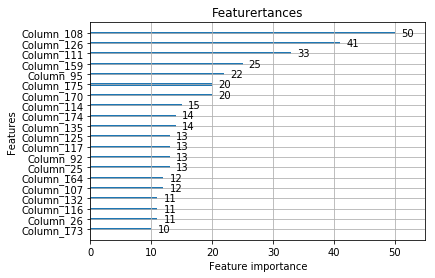

In [130]:
plt.figure(figsize=(12,6))
lgb.plot_importance(gbm, max_num_features=20)
plt.title("Featurertances")
plt.show()

In [167]:
index_0=[]
for i,j in enumerate(gbm.feature_importances_):
    if j>5:
        index_0.append(i)
print(len(index_0))

58


In [145]:
#index_0

In [168]:
x_train_1=xy_train_values[:,index_0]
x_test_1=xy_test.values[:,index_0]

In [169]:
gbm0 = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=100)
gbm0.fit(x_train_1, y_train_0,eval_set=[(x_test_1, y_test_0)],early_stopping_rounds=5)

[1]	valid_0's l2: 12954
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 11396.8
[3]	valid_0's l2: 10188.5
[4]	valid_0's l2: 9241.61
[5]	valid_0's l2: 8305.67
[6]	valid_0's l2: 7663.47
[7]	valid_0's l2: 7113.97
[8]	valid_0's l2: 6679.54
[9]	valid_0's l2: 6423.31
[10]	valid_0's l2: 6052.28
[11]	valid_0's l2: 5822.09
[12]	valid_0's l2: 5607.06
[13]	valid_0's l2: 5391.25
[14]	valid_0's l2: 5196.89
[15]	valid_0's l2: 5082.16
[16]	valid_0's l2: 4995.45
[17]	valid_0's l2: 4929.68
[18]	valid_0's l2: 4889.22
[19]	valid_0's l2: 4832.65
[20]	valid_0's l2: 4784.15
[21]	valid_0's l2: 4743.37
[22]	valid_0's l2: 4715.17
[23]	valid_0's l2: 4706.44
[24]	valid_0's l2: 4677.58
[25]	valid_0's l2: 4608.82
[26]	valid_0's l2: 4589.86
[27]	valid_0's l2: 4578.49
[28]	valid_0's l2: 4602.6
[29]	valid_0's l2: 4581.45
[30]	valid_0's l2: 4584.71
[31]	valid_0's l2: 4547.39
[32]	valid_0's l2: 4492.19
[33]	valid_0's l2: 4467.22
[34]	valid_0's l2: 4498.95
[35]	valid_0's l2: 4498.9
[36]	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### 样本时间的选择

* 越后面的样本是离预测数据越近的样本
* 训练商品与预测商品重合度

In [192]:
x_train_2=x_train_1[-6000:,:]
y_train_2=y_train_0[-6000:]

In [214]:
gbm1 = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=100)
gbm1.fit(x_train_2, y_train_2,eval_set=[(x_test_1, y_test_0)],early_stopping_rounds=5)

[1]	valid_0's l2: 12806.7
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 11183
[3]	valid_0's l2: 9842.54
[4]	valid_0's l2: 8795.39
[5]	valid_0's l2: 7942.59
[6]	valid_0's l2: 7271.91
[7]	valid_0's l2: 6736.64
[8]	valid_0's l2: 6259.37
[9]	valid_0's l2: 5910.09
[10]	valid_0's l2: 5634.49
[11]	valid_0's l2: 5355.84
[12]	valid_0's l2: 5136.29
[13]	valid_0's l2: 4952.22
[14]	valid_0's l2: 4800.07
[15]	valid_0's l2: 4681.35
[16]	valid_0's l2: 4606.04
[17]	valid_0's l2: 4529.26
[18]	valid_0's l2: 4438.65
[19]	valid_0's l2: 4404.39
[20]	valid_0's l2: 4355.41
[21]	valid_0's l2: 4282.96
[22]	valid_0's l2: 4268.11
[23]	valid_0's l2: 4252.97
[24]	valid_0's l2: 4241.44
[25]	valid_0's l2: 4233.44
[26]	valid_0's l2: 4240.95
[27]	valid_0's l2: 4250.5
[28]	valid_0's l2: 4244.43
[29]	valid_0's l2: 4230.46
[30]	valid_0's l2: 4216.7
[31]	valid_0's l2: 4200.04
[32]	valid_0's l2: 4189.85
[33]	valid_0's l2: 4185.05
[34]	valid_0's l2: 4185.09
[35]	valid_0's l2: 4192
[36]	valid

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [178]:
len(x_train_2)

3000

## 其他模型

* sklearn大部分模型的速度都比lightgbm慢很多，因此下面多数直接用样本与特征数相对少的x_train_2

### gbdt

* 上面的优化对于gbdt也是有用的

In [199]:
model_gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=50)
model_gbr.fit(x_train_0, y_train_0)
y_pred = model_gbr.predict(x_test_0)
print(mean_squared_error(y_pred, y_test_0))

5118.940822179315


In [200]:
model_gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=50)
model_gbr.fit(x_train_2, y_train_2)
y_pred = model_gbr.predict(x_test_1)
print(mean_squared_error(y_pred, y_test_0))

4455.500212482618


### svm，LinearRegression，LogisticRegression

* 多数模型需要做数据标准化的
* 传统模型多数比不上规则

In [201]:
from sklearn import svm
model_SVR = svm.SVR(gamma="scale")
model_SVR.fit(x_train_2, y_train_2)
y_pred = model_SVR.predict(x_test_1)
print(mean_squared_error(y_pred, y_test_0))

15236.961072048143


In [202]:
from sklearn.preprocessing import StandardScaler
 
x_train_2_s=StandardScaler().fit_transform(x_train_2)
x_test_1_s=StandardScaler().fit_transform(x_test_1)

In [203]:
model_SVR = svm.SVR(gamma="scale")
model_SVR.fit(x_train_2_s, y_train_2)
y_pred = model_SVR.predict(x_test_1_s)
print(mean_squared_error(y_pred, y_test_0))

11976.229755269243


In [206]:
from sklearn.linear_model import LinearRegression
model_liner = LinearRegression(fit_intercept=True)
model_liner.fit(x_train_2_s, y_train_2)
y_pred = model_liner.predict(x_test_1_s)
print(mean_squared_error(y_pred, y_test_0))

33837.99659085688


In [213]:
from sklearn.linear_model import LogisticRegression
# 定义逻辑回归模型
model_lr = LogisticRegression(solver='liblinear',multi_class='auto')
model_lr.fit(x_train_2_s, y_train_2)
y_pred = model_lr.predict(x_test_1_s)
print(mean_squared_error(y_pred, y_test_0))

10884.884287454324


## 请尝试套用“集成学习之Stacking的实现”的内容在这里实现多模型的集成学习